In [7]:
import cv2
import numpy as np
import dlib
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from skimage import feature
import os
from skimage.feature import hog

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./model/shape_predictor_68_face_landmarks.dat')

In [8]:
import pickle

file_name = './model/faceShapeFemale.pkl'
with open(file_name, 'rb') as file:
    model = pickle.load(file)

In [14]:
dir = './sample/Oblong'

In [20]:
def cropped_image(image, face):
    # Increase the bounding box size
    left = max(0, int(face.left()*0.8))
    top = max(0, int(face.top()*0.5))
    right = min(image.shape[1], int(face.right()*1.1))
    bottom = min(image.shape[0], int(face.bottom()*1.1))
    
    # Crop the face
    cropped = image[top:bottom, left:right]
    return cropped

def rescale_image(image, max_dimension=200):
    height, width = image.shape[:2]

    AR = max_dimension / max(height, width)

    # Calc the precentage
    new_width = int(width * AR)
    new_height = int(height * AR)

    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized_image

def pre_processing(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(img_gray)  
    for face in faces:
        cropped = cropped_image(img, face)
        resized_cropped = rescale_image(cropped)
        return resized_cropped
    
def extract_features(image):
    # Resize the image to 128x128
    image_resized = cv2.resize(image, (128, 128))
    # Compute HOG descriptors
    features, hog_image = hog(image_resized, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(4, 4), block_norm="L2", visualize=True)
    return features, hog_image

def skin_type(image):
    #Step 1: detect face landmark
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)  
    face = faces[0]
    landmarks = predictor(gray, face)
    face_points = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)]
    
    #Step 2: mask the details
    lefteye_points = np.array(face_points[36:41], dtype=np.int32)
    righteye_points = np.array(face_points[42:47], dtype=np.int32)
    mouth_points = np.array(face_points[48:61], dtype=np.int32)
    cut_area = [lefteye_points, righteye_points, mouth_points]
    details_removed_image = image.copy()

    ## Step 3: cut the details
    for area in cut_area:
        mask = np.zeros(details_removed_image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [area], 255)
        mask = cv2.bitwise_not(mask)
        details_removed_image = cv2.bitwise_and(details_removed_image, details_removed_image, mask=mask)

    mask = np.zeros(details_removed_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(face_points[:27], dtype=np.int32)], 255)
    masked_image = cv2.bitwise_and(details_removed_image, details_removed_image, mask=mask)

    # Step 4: Crop the face from the image
    y_values, x_values = np.where(mask == 255)
    x = min(x_values)
    y = min(y_values)
    w = max(x_values) - x
    h = max(y_values) - y
    cropped_face = masked_image[y:y+h, x:x+w]

    # Step 5: add green color to the background, prevent black color affect the kmeans results
    green_color = np.array([0, 255, 0], dtype=np.uint8)
    black_pixels_mask = np.all(cropped_face == [0, 0, 0], axis=-1)
    green_image = np.full(cropped_face.shape, green_color, dtype=np.uint8)
    cropped_face = np.where(black_pixels_mask[..., None], green_image, cropped_face)

    # Step 6: Color segmentation
    pixels = np.float32(cropped_face.reshape(-1, 3))
    n_colors = 2
    kmeans = KMeans(n_clusters=n_colors, n_init='auto')
    labels = kmeans.fit_predict(pixels)
    colors = kmeans.cluster_centers_.astype(int)

    dominant_colors = colors[np.unique(labels, return_counts=True)[1].argsort()[::-1]]
    dominant_color = next((color for color in dominant_colors if np.any(color != [0, 0, 0])), None)

    dominant_color_hsv = cv2.cvtColor(np.uint8([[dominant_color]]), cv2.COLOR_BGR2HSV)[0][0]

    # Determine the skin tone category based on the dominant color
    if dominant_color_hsv is not None and dominant_color_hsv[2] > 170:
        skin_tone_category = "Light Skin"
    else:
        skin_tone_category = "Dark Skin"

    return skin_tone_category

In [17]:
def wrapped_model(img_path):
    img = cv2.imread(img_path)
    skin_res = skin_type(img)
    img_processed = pre_processing(img)
    gray = cv2.cvtColor(img_processed, cv2.COLOR_BGR2GRAY)
    hog_feature, _ =  extract_features(gray)
    res = model.predict(hog_feature.reshape(1, -1))
    return int(res[0]), skin_res


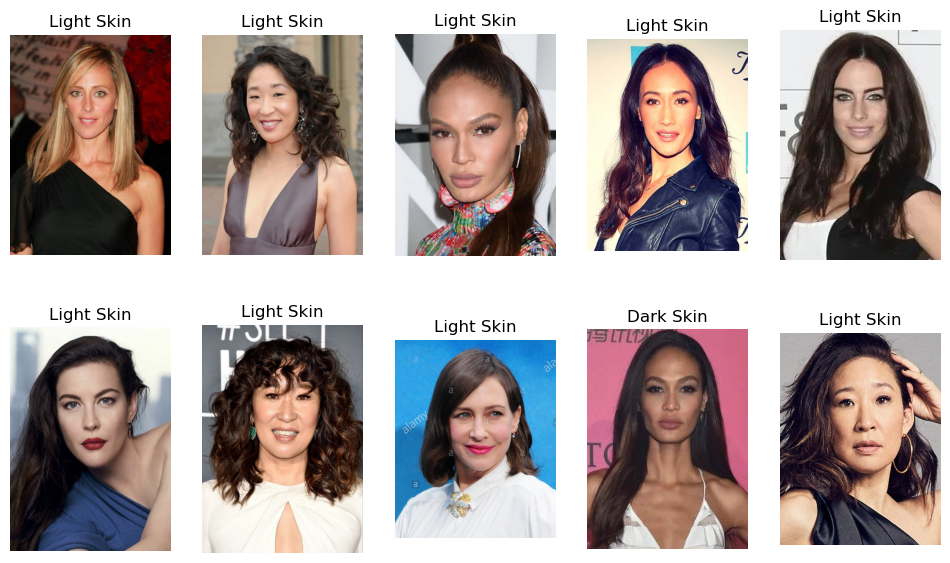

In [22]:
imgList = os.listdir(dir)
i = 0
fig, ax = plt.subplots(2, 5, figsize=(12, 7))
for imgDir in imgList:

    img_path = os.path.join(dir + "\\" + imgDir)
    faceShape, skinType = wrapped_model(img_path)

    img = cv2.imread(img_path)
    ax[i // 5, i % 5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 5, i % 5].set_title(f"{skinType}")
    ax[i // 5, i % 5].axis('off')
    i += 1